<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-06-25 14:37:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-06-25 14:37:00 (14.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

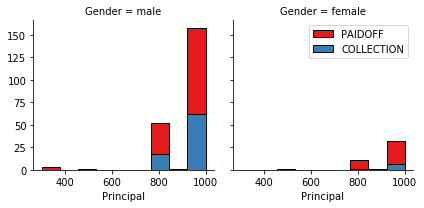

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

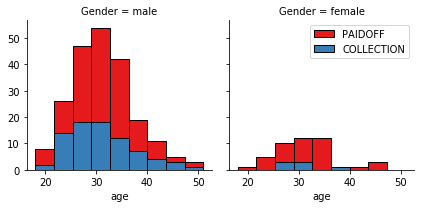

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

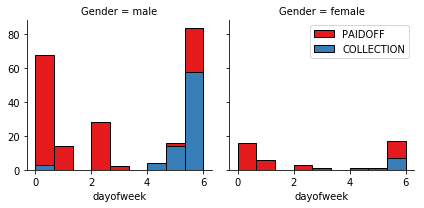

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [17]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [18]:
#create another dataframe for printing pair plot for visualization 
check = df
check = check.drop(['effective_date'], axis = 1)
check.head()
check = check.drop(['due_date'], axis = 1)
check.head()

check1 = pd.concat([check,pd.get_dummies(check['education'])],axis = 1)

In [19]:
check1 = check1.drop(['education'],axis = 1)
check1.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,0,0,PAIDOFF,1000,30,45,0,3,0,0,1,0,0
1,2,2,PAIDOFF,1000,30,33,1,3,0,1,0,0,0
2,3,3,PAIDOFF,1000,15,27,0,3,0,0,0,0,1
3,4,4,PAIDOFF,1000,30,28,1,4,1,0,0,0,1
4,6,6,PAIDOFF,1000,30,29,0,4,1,0,0,0,1


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [20]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [23]:
check1.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'age', 'Gender', 'dayofweek', 'weekend', 'Bechalor',
       'High School or Below', 'Master or Above', 'college'],
      dtype='object')

# New Feature Selection (Modified)

In [24]:
X = check1[['Unnamed: 0', 'Unnamed: 0.1', 'Principal', 'terms', 'age', 'Gender', 'dayofweek', 'weekend', 'Bechalor', 'High School or Below', 'Master or Above', 'college']]
X.head()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,0,0,1000,30,45,0,3,0,0,1,0,0
1,2,2,1000,30,33,1,3,0,1,0,0,0
2,3,3,1000,15,27,0,3,0,0,0,0,1
3,4,4,1000,30,28,1,4,1,0,0,0,1
4,6,6,1000,30,29,0,4,1,0,0,0,1


In [25]:
y = check1[['loan_status']]
y.replace(to_replace = ['COLLECTION', 'PAIDOFF'], value = [0,1], inplace = True)
y.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,loan_status
0,1
1,1
2,1
3,1
4,1


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [26]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.75351563, -1.75351563,  0.51578458,  0.92071769,  2.33152555,
        -0.42056004, -0.26122054, -1.20577805, -0.38170062,  1.13639374,
        -0.07624929, -0.86968108],
       [-1.73616849, -1.73616849,  0.51578458,  0.92071769,  0.34170148,
         2.37778177, -0.26122054, -1.20577805,  2.61985426, -0.87997669,
        -0.07624929, -0.86968108],
       [-1.72749491, -1.72749491,  0.51578458, -0.95911111, -0.65321055,
        -0.42056004, -0.26122054, -1.20577805, -0.38170062, -0.87997669,
        -0.07624929,  1.14984679],
       [-1.71882134, -1.71882134,  0.51578458,  0.92071769, -0.48739188,
         2.37778177,  0.12175534,  0.82934003, -0.38170062, -0.87997669,
        -0.07624929,  1.14984679],
       [-1.7014742 , -1.7014742 ,  0.51578458,  0.92071769, -0.3215732 ,
        -0.42056004,  0.12175534,  0.82934003, -0.38170062, -0.87997669,
        -0.07624929,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [27]:
# import all the useful packages for kNN model training
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [28]:
# convert the label "Collection" and "Paidoff" to 0 and 1, respectively for purpose of training
df['loan_status'].replace(to_replace = ['COLLECTION','PAIDOFF'], value = [0,1], inplace = True)
y = df['loan_status']

In [29]:
# split the data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)

Text(0,0.5,'accuracy')

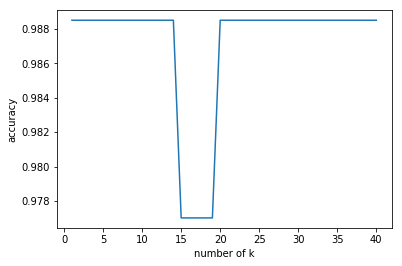

In [30]:
# in order to find the best k for kNN traning, it is important to plot out accuracy vs. k to see at which k the accuracy peaks
from sklearn.metrics import accuracy_score
y_pred_t = []
acc = []
times = 40

#this loop can calculate each value of accuracy according to different settings of k's
for i in range(times):
    knn = KNeighborsClassifier(n_neighbors = i+1)
    knn.fit(X_train, y_train)
    y_pred_t = knn.predict(X_test)
    acc.append(accuracy_score(y_test,y_pred_t))
    
#plot the accuracy vs. k
plt.figure()
plt.plot(range(1,times+1),acc)
plt.xlabel('number of k')
plt.ylabel('accuracy')

It's shown in the graph above that when k is not between 15 and 20 the accuracy reaches its peak.(0.988) So the best k is any number outside the range (15, 20)

# Decision Tree

In [31]:
# import tree package
from sklearn import tree

Text(0.5,1,'Decision tree')

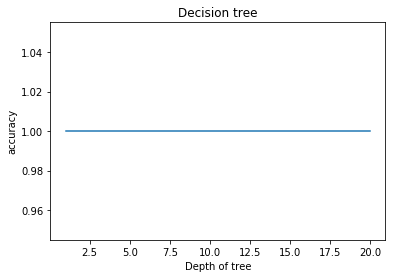

In [32]:
pred_y = []
accD = []
times = 20
for i in range(times):
    DTree = tree.DecisionTreeClassifier(max_depth = i+1, random_state = 3)
    DTree.fit(X_train, y_train)
    pred_y = DTree.predict(X_test)
    accD.append(accuracy_score(y_test, pred_y))

#plot the accuracy vs. k
plt.figure()
plt.plot(range(1,times+1),accD)
plt.xlabel('Depth of tree')
plt.ylabel('accuracy')
plt.title('Decision tree')

From the results above, it shows that the accuracy is always 1 for any numbers of depth of tree

Text(0.5,1,'Random Forest')

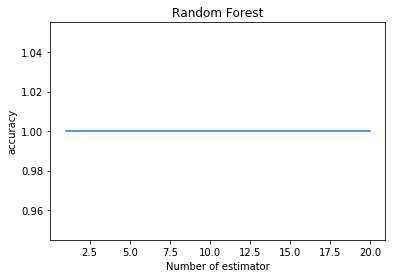

In [33]:
# random forest algorithm
from sklearn.ensemble import RandomForestClassifier
accRF = []
times = 20
for i in range(times):
    forest = RandomForestClassifier(n_estimators = i+1, random_state = 2)
    forest.fit(X_train, y_train)
    pred1 = forest.predict(X_test)
    accRF.append(accuracy_score(y_test, pred1))

#plot the accuracy vs. k
plt.figure()
plt.plot(range(1,times+1),accRF)
plt.xlabel('Number of estimator')
plt.ylabel('accuracy')
plt.title('Random Forest')

Text(0.5,1,'Gradient Boosting Tree to find Max_Depth')

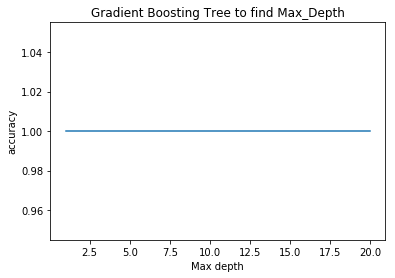

In [34]:
#Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
accBT = []
times = 20
for i in range(times):
    GBC = GradientBoostingClassifier(max_depth = i+1, random_state = 3)
    GBC.fit(X_train, y_train)
    pred1 = GBC.predict(X_test)
    accBT.append(accuracy_score(y_test, pred1))

#plot the accuracy vs. k
plt.figure()
plt.plot(range(1,times+1),accBT)
plt.xlabel('Max depth')
plt.ylabel('accuracy')
plt.title('Gradient Boosting Tree to find Max_Depth')


Text(0.5,1,'Gradient Boosting Tree')

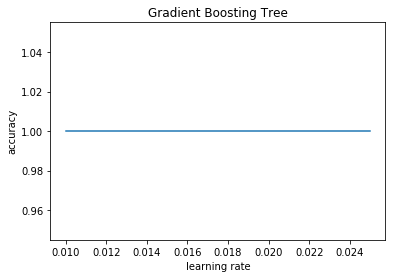

In [35]:
accBT = []
num = np.linspace(0.01,0.025,50)
for i in num:
    GBC = GradientBoostingClassifier(max_depth = 3, random_state = 3, learning_rate = i)
    GBC.fit(X_train, y_train)
    pred1 = GBC.predict(X_test)
    accBT.append(accuracy_score(y_test, pred1))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accBT)
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('Gradient Boosting Tree')

# Support Vector Machine

In [36]:
# import SVM packages for model training 
from sklearn.svm import SVC

Text(0.5,1,'RBF kernel')

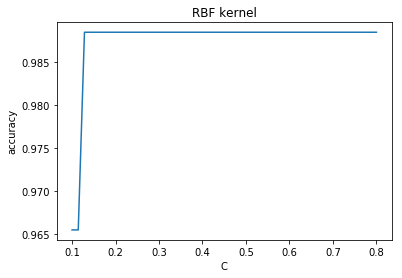

In [37]:
accsv = []
num = np.linspace(0.1,0.8,50)
for i in num:
    svmachine = SVC(C = i, kernel = 'rbf')
    svmachine.fit(X_train, y_train)
    pred2 = svmachine.predict(X_test)
    accsv.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accsv)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('RBF kernel')

It demonstrates that for RBF, C > 0.15 is best for yielding peak accuracy (0.986)

Text(0.5,1,'linear kernel')

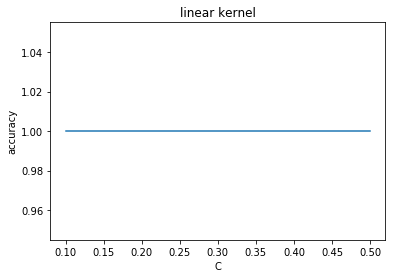

In [38]:
accsv2 = []
num = np.linspace(0.1,0.5,50)
for i in num:
    svmachine = SVC(C = i, kernel = 'linear')
    svmachine.fit(X_train, y_train)
    pred2 = svmachine.predict(X_test)
    accsv2.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accsv2)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('linear kernel')

It demonstrates that for "linear" kernel, the accuracy is invariant on any C and the accuracy is always 1

Text(0.5,1,'poly kernel')

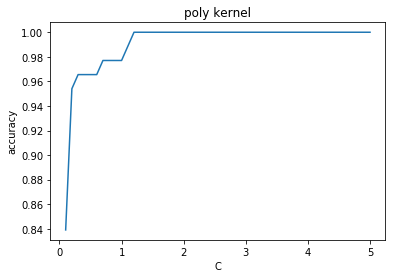

In [39]:
accsv3 = []
num = np.linspace(0.1,5,50)
for i in num:
    svmachine = SVC(C = i, kernel = 'poly')
    svmachine.fit(X_train, y_train)
    pred2 = svmachine.predict(X_test)
    accsv3.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accsv3)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('poly kernel')

It demonstrates that for "poly" kernel, the best C > 1.5, which would yield the peak accuracy. (1.00)

Text(0.5,1,'sigmoid kernel')

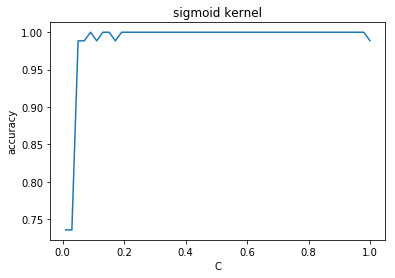

In [40]:
accsv4 = []
num = np.linspace(0.01,1,50)
for i in num:
    svmachine = SVC(C = i, kernel = 'sigmoid')
    svmachine.fit(X_train, y_train)
    pred2 = svmachine.predict(X_test)
    accsv4.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accsv4)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('sigmoid kernel')

It demonstrates that for "sigmoid" kernel, the best C > 0.25, which would yield the peak accuracy. (1.00)

Conclusively, the best choice for SVC is using the linear kernel with any C.

# Logistic Regression

Text(0.5,1,'Logistic regression - lbfgs')

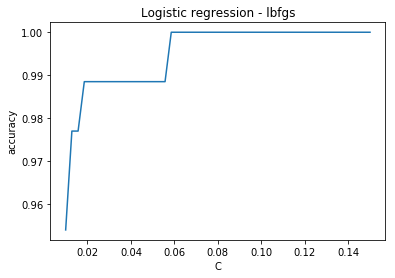

In [41]:
# import logistic regression packages for model training
from sklearn.linear_model import LogisticRegression
num = np.linspace(0.01,0.15,50)
accLR = []
for i in num:
    lgr = LogisticRegression(C = i, random_state = 3, solver = 'lbfgs', penalty = 'l2')
    lgr.fit(X_train, y_train)
    pred2 = lgr.predict(X_test)
    accLR.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accLR)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('Logistic regression - lbfgs')

for lbfgs solver, accuracy peaks at C > 0.07. (1.00)

Text(0.5,1,'Logistic regression - sag')

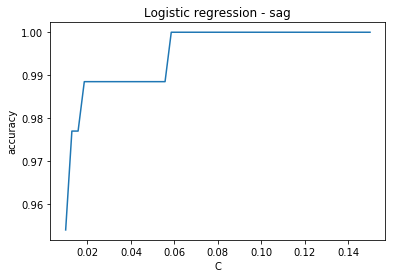

In [42]:
num = np.linspace(0.01,0.15,50)
accLR2 = []
for i in num:
    lgr = LogisticRegression(C = i, random_state = 3, solver = 'sag', penalty = 'l2')
    lgr.fit(X_train, y_train)
    pred2 = lgr.predict(X_test)
    accLR2.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accLR2)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('Logistic regression - sag')

for sag solver, the accuaracy peaks at C > 0.07 (1.00)

Text(0.5,1,'Logistic regression - saga')

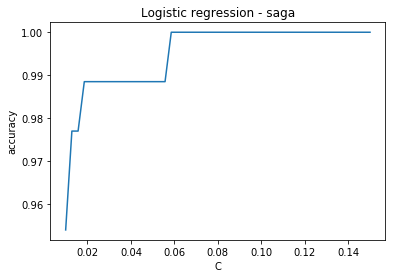

In [43]:
num = np.linspace(0.01,0.15,50)
accLR2 = []
for i in num:
    lgr = LogisticRegression(C = i, random_state = 3, solver = 'saga', penalty = 'l2')
    lgr.fit(X_train, y_train)
    pred2 = lgr.predict(X_test)
    accLR2.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accLR2)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('Logistic regression - saga')

for saga solver, the accuracy peaks at C > 0.06. (1.00)

Text(0.5,1,'Logistic regression - newton-cg')

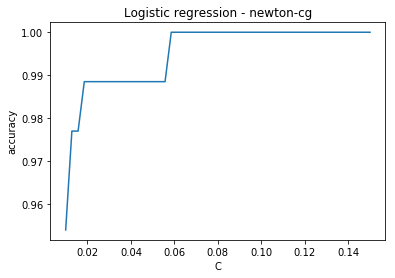

In [44]:
num = np.linspace(0.01,0.15,50)
accLR2 = []
for i in num:
    lgr = LogisticRegression(C = i, random_state = 3, solver = 'newton-cg', penalty = 'l2')
    lgr.fit(X_train, y_train)
    pred2 = lgr.predict(X_test)
    accLR2.append(accuracy_score(y_test, pred2))

#plot the accuracy vs. k
plt.figure()
plt.plot(num,accLR2)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.title('Logistic regression - newton-cg')

for newton-cg solver, the accuracy peaks at C > 0.07 (1.00)

Conclusively, for Logistic Regression, all the solvers (lbfgs, sag, saga, newton-cg) are equally good for C > 0.07. 

# Model Evaluation using Test set

In [45]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [46]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-06-25 14:37:09--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-06-25 14:37:09 (566 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [47]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [48]:
# convert the date data to datetime data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [49]:
test_df['day of week'] = test_df['effective_date'].dt.dayofweek

In [50]:
test_df['weekend'] = test_df['day of week'].apply(lambda x: 1 if (x>3) else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day of week,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [51]:
test_df['Gender'].replace(to_replace = ['male', 'female'], value = [0,1], inplace = True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,day of week,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [52]:
test_check = test_df
test_check = test_check.drop(['effective_date','due_date'], axis = 1)
test_check.head()
test_check1 = pd.concat([test_check,pd.get_dummies(test_check['education'])], axis = 1)
test_check1.head()
test_check1 = test_check1.drop(['education'], axis = 1)
test_check1.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,age,Gender,day of week,weekend,Bechalor,High School or Below,Master or Above,college
0,1,1,PAIDOFF,1000,30,50,1,3,0,1,0,0,0
1,5,5,PAIDOFF,300,7,35,0,4,1,0,0,1,0
2,21,21,PAIDOFF,1000,30,43,1,5,1,0,1,0,0
3,24,24,PAIDOFF,1000,30,26,0,5,1,0,0,0,1
4,35,35,PAIDOFF,800,15,29,0,6,1,1,0,0,0


In [53]:
test_df['education'].value_counts()

college                 23
High School or Below    21
Bechalor                 8
Master or Above          2
Name: education, dtype: int64

In [54]:
test_df[['Principal', 'terms', 'age', 'education', 'Gender']].head()

,Principal,terms,age,education,Gender
0,1000,30,50,Bechalor,1
1,300,7,35,Master or Above,0
2,1000,30,43,High School or Below,1
3,1000,30,26,college,0
4,800,15,29,Bechalor,0


In [55]:
Feature_test = test_df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
Feature_test.head()
Feature_test = pd.concat([Feature_test, pd.get_dummies(test_df['education'])], axis = 1)
Feature_test.head()
Feature_test.drop(['Master or Above'], axis = 1, inplace = True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [56]:
X_testnew = Feature_test
X_testnew.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [57]:
y_testnew = test_df['loan_status']
y_testnew.replace(to_replace = ['COLLECTION','PAIDOFF'], value = [0,1], inplace = True)

In [58]:
y_testnew.head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [59]:
test_check1.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'age', 'Gender', 'day of week', 'weekend', 'Bechalor',
       'High School or Below', 'Master or Above', 'college'],
      dtype='object')

# New Test Feature Selection (Modified)

In [60]:
X_testnew = test_check1[['Unnamed: 0', 'Unnamed: 0.1', 'Principal', 'terms', 'age', 'Gender', 'day of week', 'weekend', 'Bechalor', 'High School or Below', 'Master or Above', 'college']]
X_testnew.head()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age,Gender,day of week,weekend,Bechalor,High School or Below,Master or Above,college
0,1,1,1000,30,50,1,3,0,1,0,0,0
1,5,5,300,7,35,0,4,1,0,0,1,0
2,21,21,1000,30,43,1,5,1,0,1,0,0
3,24,24,1000,30,26,0,5,1,0,0,0,1
4,35,35,800,15,29,0,6,1,1,0,0,0


In [61]:
y_testnew = test_check1[['loan_status']]
y_testnew.replace(to_replace = ['COLLECTION','PAIDOFF'], value = [0,1], inplace = True)
y_testnew.head()

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,loan_status
0,1
1,1
2,1
3,1
4,1


In [62]:
# Feature normalization
from sklearn.preprocessing import StandardScaler
scc = StandardScaler()
X_test_scc = scc.fit_transform(X_testnew)


In [70]:
#make predictions using all the best parameters for different ML algorithms above.

#kNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test_scc)
pred_knn_prb = knn.predict_proba(X_test_scc)

#Decision Tree
dT = tree.DecisionTreeClassifier(max_depth = 3, random_state = 3)
dT.fit(X_train, y_train)
pred_dt = dT.predict(X_test_scc)
# probability not suitable for decision tree

#SVM
svm = SVC(kernel = 'linear', C = 0.2, probability = True)
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test_scc)
pred_svm_prb = svm.predict_proba(X_test_scc)

#Logistic Regression
lre = LogisticRegression(solver = 'lbfgs', penalty = 'l2', random_state = 3, C = 0.1)
lre.fit(X_train, y_train)
pred_lre = lre.predict(X_test_scc)
pred_lre_prb = lre.predict_proba(X_test_scc)

In [78]:
from sklearn.metrics import jaccard_similarity_score
for i, k in zip([pred_knn, pred_dt, pred_svm, pred_lre],["kNN", "Decision Tree", "SVM", "Logistic Regression"]):
    jaccard = jaccard_similarity_score(y_testnew, i)
    print("The jaccard accuracy for ", k, " is: %.2f" %jaccard)


The jaccard accuracy for  kNN  is: 0.98
The jaccard accuracy for  Decision Tree  is: 0.96
The jaccard accuracy for  SVM  is: 1.00
The jaccard accuracy for  Logistic Regression  is: 1.00


In [79]:
from sklearn.metrics import f1_score
for i, k in zip([pred_knn, pred_dt, pred_svm, pred_lre],["kNN", "Decision Tree", "SVM", "Logistic Regression"]):
    f1score = f1_score(y_testnew, i, average = 'weighted')
    print("The F1 score accuracy for ", k, " is: %.2f" %f1score)

The F1 score accuracy for  kNN  is: 0.98
The F1 score accuracy for  Decision Tree  is: 0.96
The F1 score accuracy for  SVM  is: 1.00
The F1 score accuracy for  Logistic Regression  is: 1.00


In [76]:
from sklearn.metrics import log_loss
for i, k in zip([pred_knn_prb, pred_svm_prb, pred_lre_prb],["kNN", "SVM", "Logistic Regression"]):
    logloss = log_loss(y_testnew, i)
    print("The log loss for ", k, " is: %.2f" %logloss)

The log loss for  kNN  is: 0.64
The log loss for  SVM  is: 0.01
The log loss for  Logistic Regression  is: 0.09


## Report
You should be able to report the accuracy of the built model using different evaluation metrics:

Conclusively, the best classifier for this loan application is to use SVM (rbf kernel and C = 0.43)

The Table below was obtained using the features provided by the default script.

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.69       | 0.78        | 10.87      |
| Decision Tree      | 0.74       | 0.85        | NaN      |
| SVM                | 0.76       | 0.86        | 8.32      |
| LogisticRegression | 0.74       | 0.85        | 8.95       |

The Table below was obtained using the features I modified based on the default script. I have added four new features (Unnamed: 0, Unnamed: 0.1, day of week, Master or Above)

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.98       | 0.99        | 0.64      |
| Decision Tree      | 0.96       | 0.97        | NaN      |
| SVM                | 1.00       | 1.00        | 0.01     |
| LogisticRegression | 1.00       | 1.00        | 0.09       |

In conclusion, using SVM (kernel = linear, C = 0.2) and Logistic regression (solver = 'lbfgs', penalty = 'l2', random_state = 3, C = 0.1) are equally good in generalization of the model.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>